Created by Zexuan Xu
A naive try to fit price and item_seq_number with deal_probability using linear regression
This obviously does not make sense, but provide an example for data processing and fitting with regression

In [1]:
import pandas as pd
import sqlite3
from sqlalchemy.engine import create_engine
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets

If you alraedy load the csv in your database, simply comment the df.to_sql line

In [2]:
df = pd.read_csv('train.csv')
avito = sqlite3.connect("avito.db")
#df.to_sql('train', avito)

In [3]:
#df = pd.read_csv('test.csv')
#df.to_sql('test', avito)

In [4]:
train = pd.read_sql('SELECT * FROM train WHERE price > 10000', avito)

We only try to fit the items with price < 100000 in this naive case

In [50]:
price_train = pd.read_sql('SELECT price,item_seq_number,deal_probability FROM train WHERE price < 100000', avito).dropna()
price_train
list(price_train)[0:2]

['price', 'item_seq_number']

In [40]:
X_train = price_train[['price','item_seq_number']].values
y_train = price_train['deal_probability'].values
#X_train.feature_names = ['price','item_seq_number']
y_train

array([0.12789, 0.     , 0.43177, ..., 0.6    , 0.     , 0.     ])

In [41]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
print(regr.coef_)
print(regr.intercept_)

[ 1.88303783e-06 -2.20772813e-06]
0.12597549245981382


[array([400.,   2.]),
 array([3000.,   19.]),
 array([4000.,    9.]),
 array([2200.,  286.]),
 array([4.e+04, 3.e+00]),
 array([1300.,    9.]),
 array([11000.,   125.]),
 array([500.,  61.]),
 array([500.,  85.]),
 array([400., 136.]),
 array([1.8e+04, 6.0e+00]),
 array([1., 4.]),
 array([70., 15.]),
 array([2500.,   47.]),
 array([5000.,    6.]),
 array([800.,  86.]),
 array([500.,   9.]),
 array([1000.,    4.]),
 array([2600.,   33.]),
 array([1300.,   59.]),
 array([1500.,  309.]),
 array([1000.,   59.]),
 array([1500.,    8.]),
 array([1000.,   12.]),
 array([200.,  20.]),
 array([130.,  18.]),
 array([ 300., 3377.]),
 array([6.5e+04, 1.0e+00]),
 array([9000.,   67.]),
 array([4000.,   80.]),
 array([800., 295.]),
 array([1000.,   11.]),
 array([300.,  65.]),
 array([500.,  13.]),
 array([500.,  74.]),
 array([ 400., 2062.]),
 array([350.,  13.]),
 array([600., 204.]),
 array([500.,   8.]),
 array([2000.,   28.]),
 array([5.e+03, 1.e+00]),
 array([700., 133.]),
 array([300.,  18.])

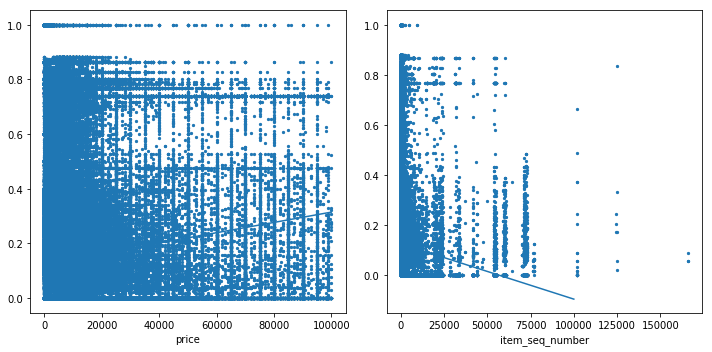

In [53]:
plt.figure(figsize=(10, 5))
linex = np.linspace(0.0, 100000.0, num=100)
for i, feat_name in enumerate(list(price_train)[0:2]):
    plt.subplot(1, 2, i+1)
    plt.scatter(X_train[:,i], y_train, s=5)
    plt.plot(linex, linex*regr.coef_[i]+regr.intercept_)
    plt.xlabel(feat_name)
plt.tight_layout()